# Churn Prediction

## Problem Statement

There is a telecom company that offers phone and internet services. There is a problem: some of our customers are churning. We would like to build a model that can identify the customers that are likely to churn. We have collected a dataset about our customers: what type of services they use, how much they paid, and how long they stayed with us. We also know who canceled their contracts and stopped using our services (churned). 

## What's in this section

In this notebook, we are going to work in phase II of our model training. This includes use of `Synthetic Minority Oversampling Technique (SMOTE)` and subsequently evaluating the models.

## Imports

In [1]:
# usual imports 
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import math

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
# plt.style.use('seaborn')

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from collections import defaultdict
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG,display

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.dummy import DummyClassifier

# helper functions
from churn_prediction_utils import *

In [2]:
%store -r df_train_full_explore
%store -r df_train_full
%store -r df_train
%store -r df_val
%store -r df_test

%store -r y_train_full
%store -r y_train
%store -r y_val
%store -r y_test

%store -r categorical_features
%store -r numerical_features

%store -r X_train_full_scaled
%store -r dv_full_scaled
%store -r standard_scalar_full_data
%store -r feature_names

%store -r X_train_full_scaled
%store -r X_train_full_not_scaled
%store -r X_train_scaled
%store -r X_train_not_scaled
%store -r X_val_scaled
%store -r X_val_not_scaled
%store -r X_test_scaled
%store -r X_test_not_scaled

%store -r evaluation_metrics
%store -r f_scorer

%store -r phase_one_model_to_evaluation_metrics_df

## Phase II

### Synthetic Minority Oversampling Technique (SMOTE)

In [3]:
smote_model_names_to_model_objects_map = get_smote_model_names_to_model_objects_map()

Training : LR
              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81      4113
         1.0       0.52      0.80      0.63      1521

    accuracy                           0.75      5634
   macro avg       0.71      0.76      0.72      5634
weighted avg       0.80      0.75      0.76      5634

Training : DT
              precision    recall  f1-score   support

         0.0       0.88      0.73      0.80      4113
         1.0       0.50      0.73      0.59      1521

    accuracy                           0.73      5634
   macro avg       0.69      0.73      0.69      5634
weighted avg       0.78      0.73      0.74      5634

Training : RF
              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83      4113
         1.0       0.54      0.74      0.63      1521

    accuracy                           0.76      5634
   macro avg       0.72      0.76      0.73      5634
weighted avg       0.80      0.7

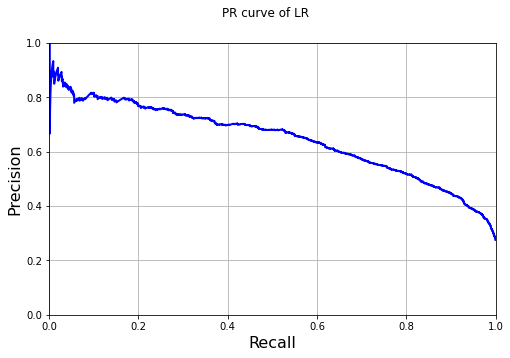

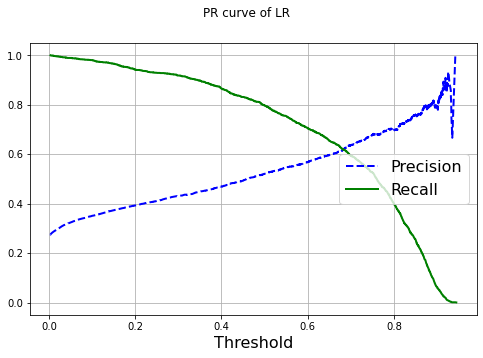

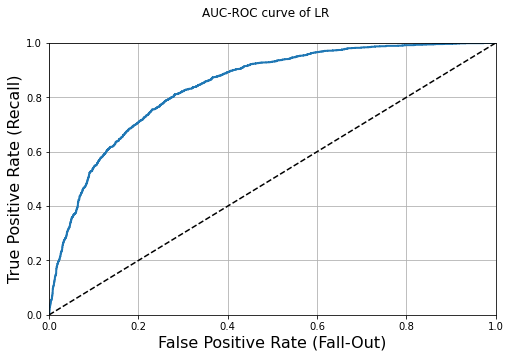

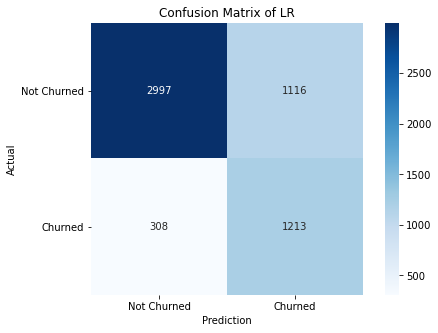

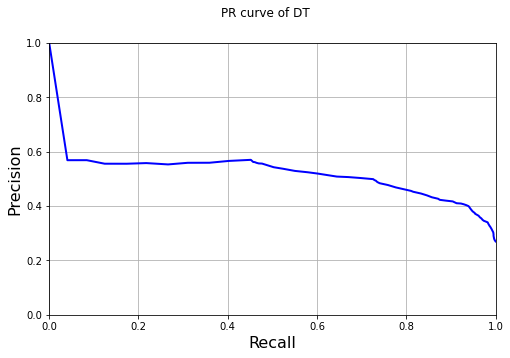

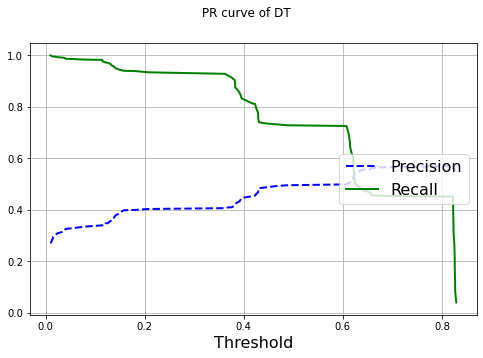

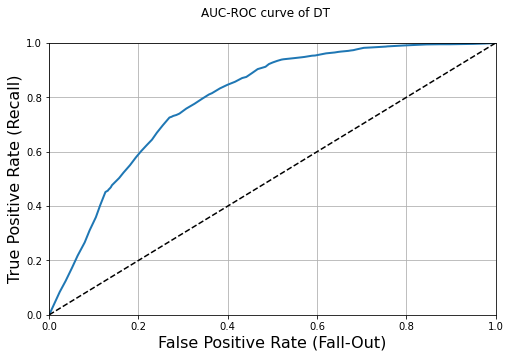

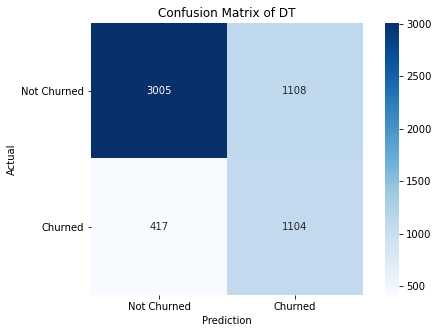

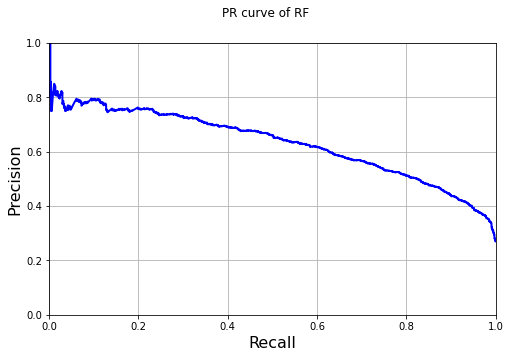

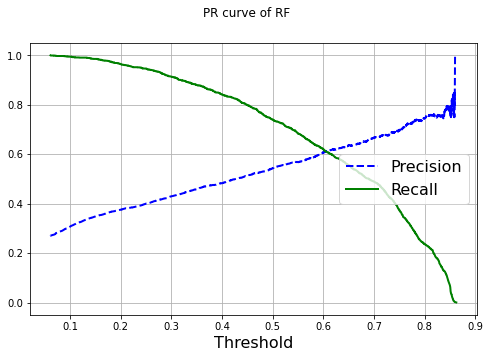

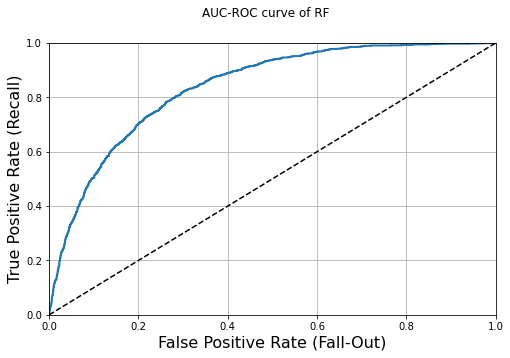

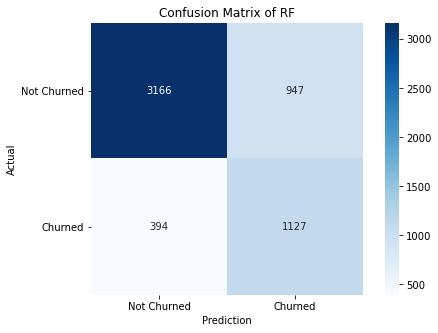

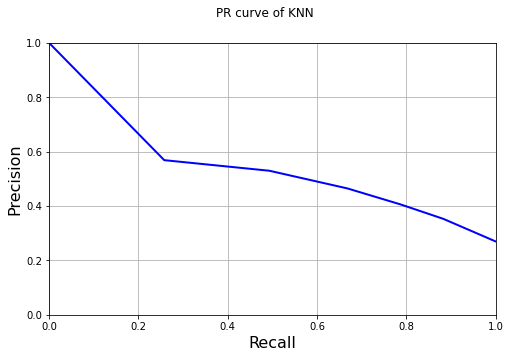

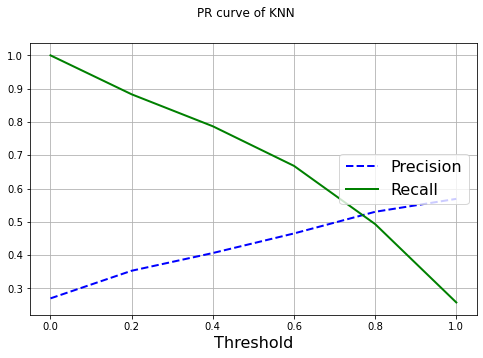

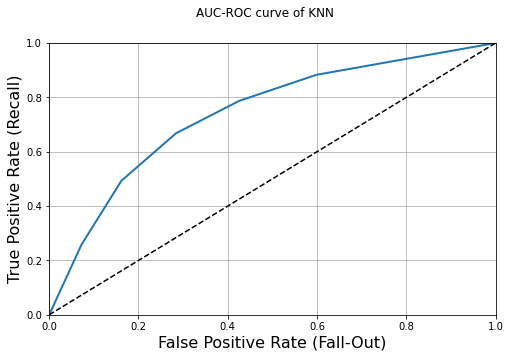

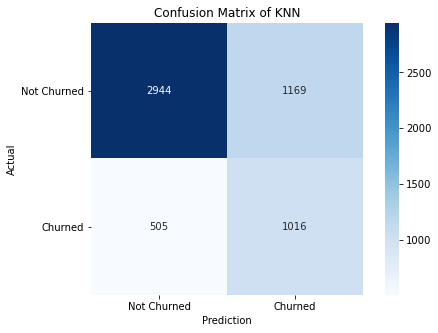

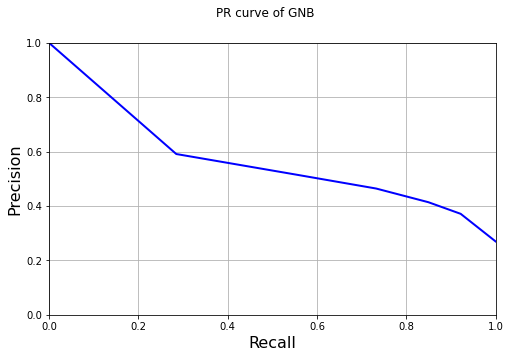

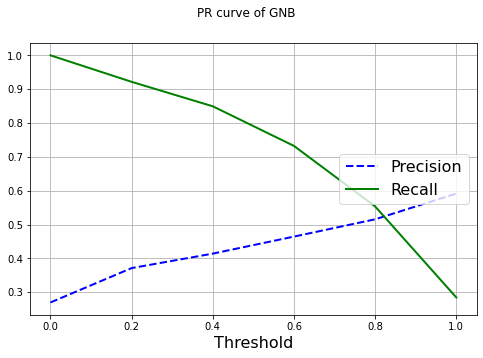

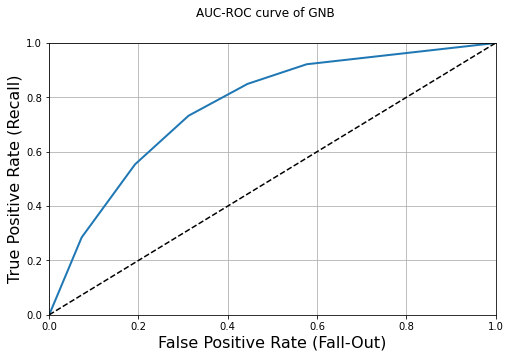

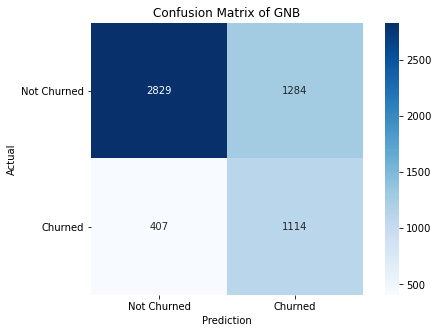

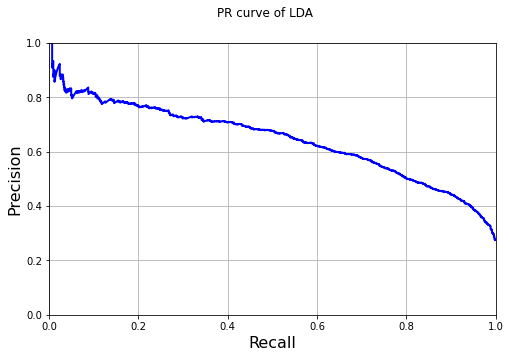

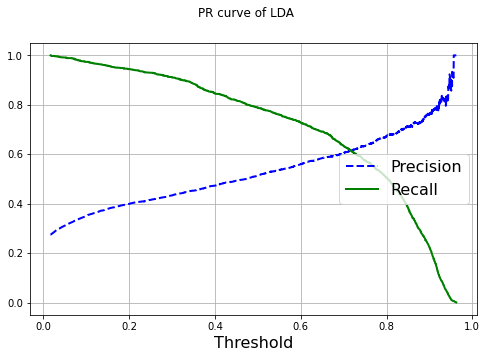

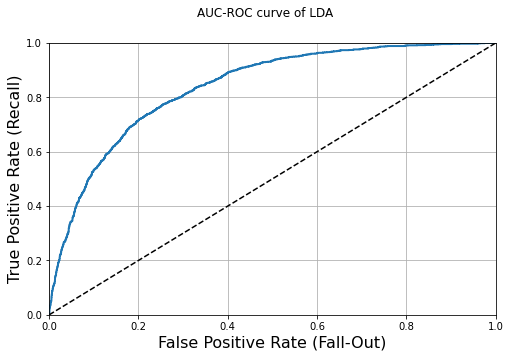

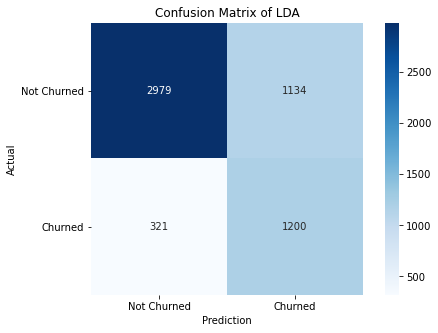

In [4]:
model_to_evaluation_metrics_with_smote_map = get_model_to_evaluation_metrics_with_smote_map(smote_model_names_to_model_objects_map, 
                                                                                            X_train_full_scaled,
                                                                                            y_train_full, 
                                                                                            X_train_full_not_scaled,
                                                                                            evaluation_metrics)

In [5]:
# Separately training for SVC
smote_model_names_to_model_objects_map['B_SVC']  = {
    'definition' : OneVsRestClassifier(
    BaggingClassifier(
        SVC(kernel='linear', probability=True, random_state= 7), 
                      max_samples=1.0 / 5, 
                      n_estimators=5)
),
    'options' : {'scaling_required' : True, 'kfold' : 5}
}
_, _ = train_and_evaluate_model_with_smote(smote_model_names_to_model_objects_map['B_SVC']['definition'], 
                                    X_train_scaled, y_train, X_val_scaled, y_val,
                           model_to_evaluation_metrics_with_smote_map, 'B_SVC', evaluation_metrics)

In [6]:
model_to_mean_evaluation_metrics_with_smote_df = get_model_to_mean_evaluation_metrics_with_smote_df(
    model_to_evaluation_metrics_with_smote_map, evaluation_metrics)

In [7]:
model_to_mean_evaluation_metrics_with_smote_df

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.685354,0.630107,0.841196,0.797519,0.521142,0.747247
1,DT,0.636844,0.591624,0.791567,0.725860,0.499632,0.729318
2,RF,0.666404,0.627118,0.837751,0.740987,0.544078,0.761982
3,KNN,0.588759,0.548260,0.739152,0.667982,0.465316,0.702872
4,GNB,0.622011,0.568577,0.766290,0.732405,0.464943,0.699860
5,LDA,0.677498,0.622697,0.838220,0.788966,0.514777,0.741742
6,B_SVC,0.670541,0.604438,0.831488,0.812757,0.481121,0.722043


In [8]:
phase_one_model_to_evaluation_metrics_df

,model_name,f1.5,f1,roc_auc,recall,precision,accuracy
0,LR,0.582117,0.601705,0.841965,0.553569,0.660453,0.802454
1,DT,0.449512,0.495489,0.813864,0.391847,0.680234,0.786120
2,RF,0.497648,0.537176,0.840648,0.445756,0.680625,0.793930
3,KNN,0.541260,0.549162,0.779625,0.529253,0.571309,0.765529
4,B_SVC,0.572627,0.589990,0.831084,0.556849,0.654509,0.799608
5,GNB,0.667782,0.592313,0.813847,0.838949,0.457860,0.688140
6,LDA,0.572806,0.589451,0.833326,0.548314,0.638680,0.793933


Lets compare models performance with oversampling of minority class and without oversampling.

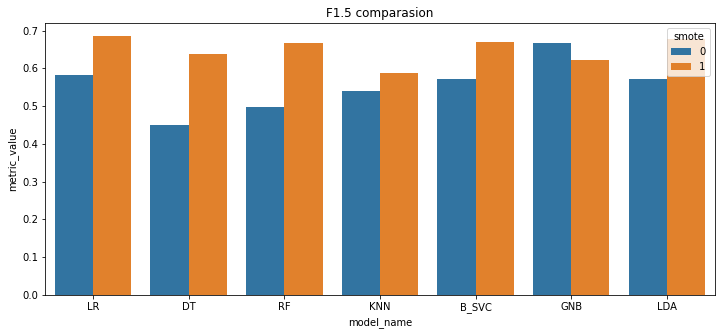

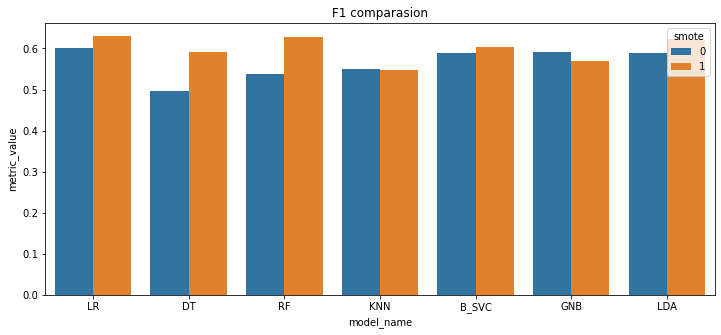

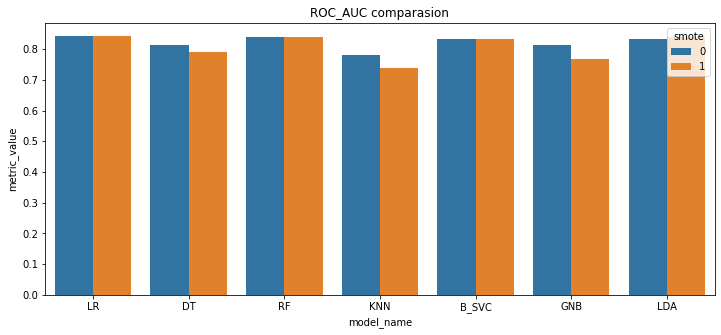

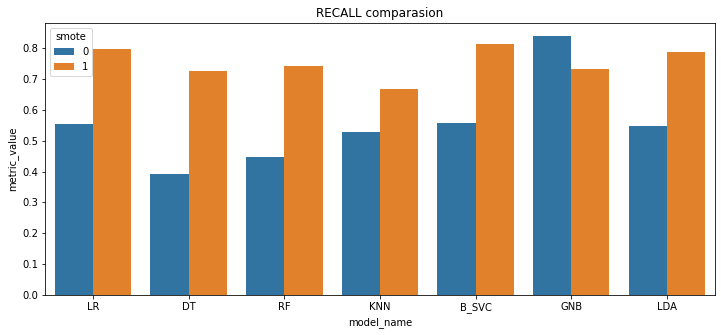

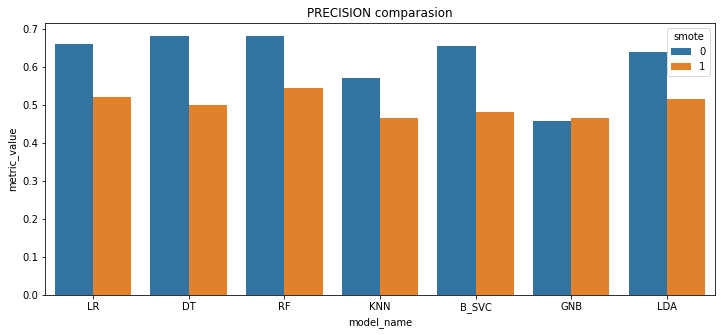

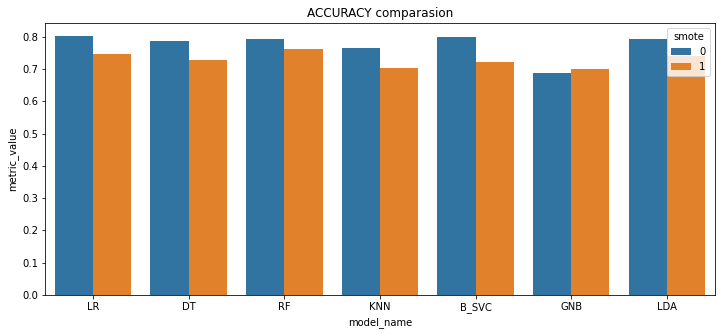

In [9]:
model_to_evaluation_metrics_type_and_value_df = phase_one_model_to_evaluation_metrics_df.melt(id_vars = "model_name", var_name = "metric_type", value_name = "metric_value")
model_to_evaluation_metrics_type_and_value_df['smote'] = 0

model_to_mean_evaluation_metrics_type_and_value_with_smote_df = model_to_mean_evaluation_metrics_with_smote_df.melt(id_vars = "model_name", var_name = "metric_type", value_name = "metric_value")
model_to_mean_evaluation_metrics_type_and_value_with_smote_df['smote'] = 1

model_with_evaluation_metrics_with_smote_and_no_smote_df = model_to_evaluation_metrics_type_and_value_df.append(
    model_to_mean_evaluation_metrics_type_and_value_with_smote_df)

for metric_name in evaluation_metrics:
    fig, axis = plt.subplots(1, 1, figsize=(12,5))
    axis.set_title("{} comparasion".format(metric_name.upper()))
    ax = sns.barplot(x = 'model_name', 
                     y = 'metric_value', 
                     hue='smote', 
                     data = model_with_evaluation_metrics_with_smote_and_no_smote_df[model_with_evaluation_metrics_with_smote_and_no_smote_df['metric_type'] == metric_name], 
                     ax = axis)

We can see from the graphs aboves that SMOTE has helped in improving the performance metrics of models that are relevant to the problem we are solving : `fbeta` and `fscore`. We would now like to try out some feature selection techniques and assess the performance of models.

In [11]:
%store model_to_mean_evaluation_metrics_with_smote_df
%store model_to_evaluation_metrics_with_smote_map

Stored 'model_to_mean_evaluation_metrics_with_smote_df' (DataFrame)
Stored 'model_to_evaluation_metrics_with_smote_map' (dict)
